In [1]:
#All neccesary classes for project

#general
import seaborn as sns
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import pickle
import time

#for preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf

#for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#for evaluation
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import DataFrameSelector
from Utilities.utilities import CategoricalEncoder
from Utilities.utilities import display_scores
from Utilities.utilities import pipeline_transform
from Utilities.utilities import reset_graph
from Utilities.models import DNN_Model
from Utilities.models import cross_val_score_dnn
from functools import partial

#image manipulation
from PIL import Image as PI
from resizeimage import resizeimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import vgg_preprocessing
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2
import pnasnet as nas

#Import Custom Functions
from Utilities.model_builder import get_image
from Utilities.model_builder import get_file_lists
from Utilities.model_builder import parse_record
from Utilities.model_builder import get_batch
from Utilities.model_builder import build_iterator
from Utilities.model_builder import get_values
from Utilities.models import log_dir_build
from Utilities.utilities import generate_image
from Utilities.utilities import generate_image_array
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset

Using TensorFlow backend.


# Load the Data

Here we will load the training and validation data in order to do training

In [ ]:
#Build tf_records
validation_directory = "C:/AI/Cell_Net_v2/training_data/validation"
train_directory = "C:/AI/Cell_Net_v2/training_data/train"
output_directory = "C:/AI/Cell_Net_v2/training_data/tf_records"
labels_file = "C:/AI/Cell_Net_v2/training_data/labels.txt"
num_threads = 2
num_shards = 2

#make validation records
process_dataset('validation', validation_directory, num_shards, labels_file, num_threads, output_directory)

#make validation records
process_dataset('train', train_directory, num_shards, labels_file, num_threads, output_directory)


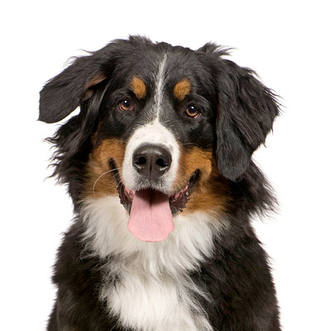

In [6]:
#Import TFRecords for both Training and Testing of the Dat
#Use the build_image_data.py to create these sets from your data
train_list, val_list = get_file_lists("C:/AI/Cell_Net_v2/training_data/tf_records")
labels = ["Punctate", "Striated"]


#Nasnet Model Location
nas_net_model = 'C:/AI/pnas_net/model.ckpt'
cell_net_logs = 'C:/AI/Cell_Net_Raw/logs'
cell_net_model = 'C:/AI/Cell_Net_Raw/model/cell_net'
cell_net_best = 'C:/AI/Cell_Net_Raw/model/cell_net_best'

test_image = generate_image_array('C:/AI/Cell_Net_v2/test_image/test.jpg', 331, 331)
test_image_raw = generate_image('C:/AI/Cell_Net_v2/test_image/test.jpg', 331, 331)
test_image_raw

# Build the Neural Network on top of Large Nas-Net

Here we will build the Nas-Net and then stack our own network on top

In [7]:
#Reset the graph 
reset_graph()

#Set constants for Neural Network
dropout_rate = 0.5
learning_rate = 0.001
n_hidden1 = 500
n_final_layer = 2


#Placeholder for input data
X = tf.placeholder(tf.float32, shape=[None, 331, 331, 3], name="input")
y = tf.placeholder(tf.int32, shape=[None], name="output")
training = tf.placeholder_with_default(False, shape=(), name = 'training')

#Define initalizer and batch normalization layers
bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
he_init = tf.contrib.layers.variance_scaling_initializer()


#Import the Nas_Net and build it
with slim.arg_scope(nas.pnasnet_large_arg_scope()):
    net, end_points = nas.build_pnasnet_large(X, num_classes=1001, is_training=False)
    
    #A saver to load the pretrained Data
    saver = tf.train.Saver(name="Original_Saver")
    
    #For getting predictions from Original Network
    soft_max_pna = tf.get_default_graph().get_tensor_by_name("final_layer/predictions:0")
    
    #Load in the noder where we are going to connect our own network
    last_feature_node = tf.get_default_graph().get_tensor_by_name("final_layer/dropout/Identity:0")


with tf.name_scope("DNN_Classifier"):
    #Use a stop layer to freeze all the layers beneath in Nas-Net
    with tf.name_scope("Hidden_Layer_1"):
        #stop_layer = tf.stop_gradient(last_feature_node)
        #hidden1 = tf.layers.dense(stop_layer, n_hidden1, name="hidden1", kernel_initializer=he_init)
        hidden1 = tf.layers.dense(last_feature_node, n_hidden1, name="hidden1", kernel_initializer=he_init)
        hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
        bn1 = bn_batch_norm_layer(hidden1_drop)
        bn1_act = tf.nn.relu(bn1)
    
    with tf.name_scope("Final_Layer"):
        logits_before_bn = tf.layers.dense(bn1_act, n_final_layer, name="outputs")
        logits = bn_batch_norm_layer(logits_before_bn, name="logits")
        softmax = tf.nn.softmax(logits)
    
    with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(xentropy, name="loss")
            loss_summary = tf.summary.scalar('loss_summary', loss)
            
    with tf.name_scope("train"):
        global_step = tf.Variable(0, trainable=False, name='global_step')
        decay_steps = 800
        decay_rate = 1/8
        learning_decay = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_decay, momentum=0.9, use_nesterov=True)
        training_op = optimizer.minimize(loss, global_step=global_step)
        

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        accuracy_summary = tf.summary.scalar('accuracy_summary', accuracy)
        
        
            
#Variables for global initialization
saver2 = tf.train.Saver(name="Full_Saver")
init = tf.global_variables_initializer()
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

#filewriter = tf.summary.FileWriter(cell_net_logs, tf.get_default_graph())

INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.


In [10]:
#Initialize all variables and restore the lower layer
with tf.Session() as sess:
    #Initalizer all variables
    init.run()
    
    #Restore the pretrained variables from Nas-Net
    saver.restore(sess, nas_net_model)
    
    
    #Save all of these variables to the new Cell_Net Model
    saver2.save(sess, cell_net_model)
    saver2.save(sess, cell_net_best)

INFO:tensorflow:Restoring parameters from C:/AI/pnas_net/model.ckpt


In [ ]:
#For Exporting Graph
filewriter = tf.summary.FileWriter(cell_net_logs, tf.get_default_graph())

# Build Testing

Here we will make sure the pre-trained network loaded and is effective with Imagenet.
If correct using first of Imagenet test it should print 286

In [32]:
with tf.Session() as sess:
    saver2.restore(sess, cell_net_model)
    y_raw = soft_max_pna.eval(feed_dict={X: test_image})
    
frame = pd.DataFrame(y_raw)
item = frame.iloc[0,:]
item = pd.Series.idxmax(item)
item

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_v3/model/cell_net


240

# Train the Network

Here we are going to train the network. Accuracy/Loss is recorded

In [33]:
# Save the Graph into a file with Filewriter and add summaries for this session
#This will be used for all the following
model_path = log_dir_build(cell_net_logs, "cell_out")
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

In [34]:
#For doing the initial training
#Total number of epochs to train
num_epochs = 100
steps_between_test_save = 5
batch_size = 5
train_size = 40
all_data_steps = np.int(np.floor(train_size/batch_size))
lowest_loss = 100


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, cell_net_model)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    iterator_train = build_iterator(True, train_list, batch_size, num_epochs=num_epochs, num_parallel_calls=8)
    iterator_test = build_iterator(False, val_list, batch_size, num_epochs=num_epochs, num_parallel_calls=4)
    next_train = iterator_train.get_next()
    next_test = iterator_test.get_next()
    
    #Get initial loss
    X_val, y_val = next_test
    X_val, y_val = get_values(sess, X_val, y_val)
    acc_sum, loss_sum, loss_val = sess.run([accuracy_summary, loss_summary, loss], feed_dict = {X: X_val, y: y_val, training: False})
    filewriter.add_summary(acc_sum, step)
    filewriter.add_summary(loss_sum, step)
    print("Epoch: " + str(step) + " Loss: " + str(loss_val))
    
    #Iterate through training 
    while step < num_epochs:
        for i in range(all_data_steps):
            #Get training data
            X_val, y_val = next_train
            X_val, y_val = get_values(sess, X_val, y_val)
        
            #run Training Op
            sess.run([training_op, extra_update_ops, accuracy_summary], feed_dict={X: X_val, y: y_val, training: True})
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            X_val, y_val = next_test
            X_val, y_val = get_values(sess, X_val, y_val)
            acc_sum, loss_sum, loss_val = sess.run([accuracy_summary, loss_summary, loss], feed_dict = {X: X_val, y: y_val, training: False})
            filewriter.add_summary(acc_sum, step)
            filewriter.add_summary(loss_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            saver2.save(sess, cell_net_model)
            if lowest_loss > loss_val:
                lowest_loss = loss_val
                saver2.save(sess, cell_net_best)
        step = step + 1
            
    #Finish the final Model
    saver2.save(sess, cell_net_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")
    print("Done!")

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_v3/model/cell_net
Loaded model. Training network initially. Logs into: C:/AI/Cell_Net_v3/logs/cell_out-run-20180613221426/
Epoch: 0 Loss: 0.700584
Epoch: 5 Loss: 0.0897908
Epoch: 10 Loss: 0.0985085
Epoch: 15 Loss: 0.123223
Epoch: 20 Loss: 0.103708
Epoch: 25 Loss: 0.0937683
Epoch: 30 Loss: 0.100111
Epoch: 35 Loss: 0.0764613
Epoch: 40 Loss: 0.0938847
Epoch: 45 Loss: 0.105796
Epoch: 50 Loss: 0.097321
Epoch: 55 Loss: 0.0952291
Epoch: 60 Loss: 0.0530423
Epoch: 65 Loss: 0.0707191
Epoch: 70 Loss: 0.101922
Epoch: 75 Loss: 0.0734559
Epoch: 80 Loss: 0.0768943
Epoch: 85 Loss: 0.0700465
Epoch: 90 Loss: 0.079259
Epoch: 95 Loss: 0.0817259
Did 800 of loss minimized training in 885.0762724876404 seconds.
Done!


In [35]:
#For picking up with additional training
#Total number of epochs to train
num_epochs = 200
steps_between_test_save = 5
batch_size = 5
train_size = 40
all_data_steps = np.int(np.floor(train_size/batch_size))

with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, cell_net_model)
    
    #Set up the global steps
    step = tf.train.global_step(sess, global_step)
    step = np.int(np.floor(step/all_data_steps))
    print("Loaded model. Starting training from epoch: " + str(step) + ", Logging in directory: " + model_path)
    
    #Build iterators to pull train and test data
    iterator_train = build_iterator(True, train_list, batch_size, num_epochs=num_epochs - step, num_parallel_calls=8)
    iterator_test = build_iterator(False, val_list, batch_size, num_epochs=num_epochs, num_parallel_calls=4)
    next_train = iterator_train.get_next()
    next_test = iterator_test.get_next()
    


    #Iterate through training 
    while step < num_epochs:
        #Go over all the data
        for i in range(all_data_steps):
            #Get training data
            X_val, y_val = next_train
            X_val, y_val = get_values(sess, X_val, y_val)
        
            #run Training Op
            sess.run([training_op, extra_update_ops, accuracy_summary], feed_dict={X: X_val, y: y_val, training: True})
        
        #Maybe Test Accuracy
        if (step % steps_between_test_save) == 0:
            X_val, y_val = next_test
            X_val, y_val = get_values(sess, X_val, y_val)
            acc_sum, loss_sum, loss_val = sess.run([accuracy_summary, loss_summary, loss], feed_dict = {X: X_val, y: y_val, training: False})
            filewriter.add_summary(acc_sum, step)
            filewriter.add_summary(loss_sum, step)
            saver2.save(sess, cell_net_model)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            if lowest_loss > loss_val:
                lowest_loss = loss_val
                saver2.save(sess, cell_net_best)
        step = step + 1
            
    #Finish the final Model
    saver2.save(sess, cell_net_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")
    print("Done!")

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_v3/model/cell_net
Loaded model. Starting training from epoch: 100, Logging in directory: C:/AI/Cell_Net_v3/logs/cell_out-run-20180613221426/
Epoch: 100 Loss: 0.0780504
Epoch: 105 Loss: 0.0652211
Epoch: 110 Loss: 0.0816667
Epoch: 115 Loss: 0.0709497
Epoch: 120 Loss: 0.0760638
Epoch: 125 Loss: 0.0457527
Epoch: 130 Loss: 0.0746388
Epoch: 135 Loss: 0.0496457
Epoch: 140 Loss: 0.069042
Epoch: 145 Loss: 0.0635618
Epoch: 150 Loss: 0.0795265
Epoch: 155 Loss: 0.0508347
Epoch: 160 Loss: 0.0590328
Epoch: 165 Loss: 0.0642946
Epoch: 170 Loss: 0.0720378
Epoch: 175 Loss: 0.0594232
Epoch: 180 Loss: 0.078906
Epoch: 185 Loss: 0.0606648
Epoch: 190 Loss: 0.0584681
Epoch: 195 Loss: 0.078923
Did 1600 of loss minimized training in 877.5314371585846 seconds.
Done!


In [37]:
#For doing the initial training
#Testing
#Total number of epochs to train
num_epochs = 50
steps_between_test_save = 20
batch_size = 5
train_size = 40
all_data_steps = np.int(np.floor(train_size/batch_size))
last_layers = np.array([])



with tf.Session() as sess:
    #restore saver, build iterator, set the step to the global step
    start_time = time.time()
    saver2.restore(sess, cell_net_model)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    iterator_train = build_iterator(True, train_list, batch_size, num_epochs=num_epochs, num_parallel_calls=8)
    iterator_test = build_iterator(False, val_list, batch_size, num_epochs=num_epochs, num_parallel_calls=4)
    next_train = iterator_train.get_next()
    next_test = iterator_test.get_next()

    #Iterate through training 
    while step < num_epochs:
        
        #Get training data
        X_val, y_val = next_train
        X_val, y_val = get_values(sess, X_val, y_val)

        #run Training Op
        sess.run([training_op, extra_update_ops, accuracy_summary], feed_dict={X: X_val, y: y_val, training: True})
        current_last = last_feature_node.eval(feed_dict={X:X_val})
        last_layers = np.append(last_layers,current_last)
        #Maybe Test Accuracy
        X_val, y_val = next_test
        X_val, y_val = get_values(sess, X_val, y_val)
        acc_sum, loss_sum, loss_val = sess.run([accuracy_summary, loss_summary, loss], feed_dict = {X: X_val, y: y_val, training: False})
        filewriter.add_summary(acc_sum, step)
        filewriter.add_summary(loss_sum, step)
        print("Epoch: " + str(step) + " Loss: " + str(loss_val))
        step = step + 1
            
    #Finish the final Model
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    saver2.save(sess, cell_net_model)
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " time.")
    print("Done!")

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_v2/model/cell_net
Loaded model. Training network initially. Logs into: C:/AI/Cell_Net_v2/logs/cell_out-run-20180612210412/
Epoch: 0 Loss: 1.31359e+09
Epoch: 1 Loss: 15.631
Epoch: 2 Loss: 5.5989
Epoch: 3 Loss: 5.56974
Epoch: 4 Loss: 4.8441
Epoch: 5 Loss: 7.23256
Epoch: 6 Loss: 3.44824
Epoch: 7 Loss: 2.50847
Epoch: 8 Loss: 0.838452
Epoch: 9 Loss: 3.99542
Epoch: 10 Loss: 1.92004
Epoch: 11 Loss: 1.92797
Epoch: 12 Loss: 1.56632
Epoch: 13 Loss: 0.806522
Epoch: 14 Loss: 0.531574
Epoch: 15 Loss: 0.945605
Epoch: 16 Loss: 0.670011
Epoch: 17 Loss: 1.25973
Epoch: 18 Loss: 1.77117
Epoch: 19 Loss: 0.644664
Epoch: 20 Loss: 0.574298
Epoch: 21 Loss: 1.59496
Epoch: 22 Loss: 1.13622
Epoch: 23 Loss: 1.12575
Epoch: 24 Loss: 0.905774
Epoch: 25 Loss: 0.931094
Epoch: 26 Loss: 0.919483
Epoch: 27 Loss: 0.682884
Epoch: 28 Loss: 1.16043
Epoch: 29 Loss: 0.67443
Epoch: 30 Loss: 1.02094
Epoch: 31 Loss: 0.542822
Epoch: 32 Loss: 0.835304
Epoch: 33 Loss: 0.625661

In [ ]:
#For doing the initial training
#Testing
#Total number of epochs to train
num_epochs = 1
batch_size = 5
train_size = 40
all_data_steps = np.int(np.floor(train_size/batch_size))
last_layers = np.array([])



with tf.Session() as sess:
    #restore saver, build iterator, set the step to the global step
    start_time = time.time()
    saver2.restore(sess, cell_net_model)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    iterator_train = build_iterator(True, train_list, batch_size, num_epochs=num_epochs, num_parallel_calls=8)
    iterator_test = build_iterator(False, val_list, batch_size, num_epochs=num_epochs, num_parallel_calls=4)
    next_train = iterator_train.get_next()
    next_test = iterator_test.get_next()

    #Iterate through training 
    while step < num_epochs:
        
        #Get training data
        X_val, y_val = next_train
        X_val, y_val = get_values(sess, X_val, y_val)

        #run Training Op
        sess.run([training_op, extra_update_ops, accuracy_summary], feed_dict={X: X_val, y: y_val, training: True})
        current_last = last_feature_node.eval(feed_dict={X:X_val})
        last_layers = np.append(last_layers,current_last)
        #Maybe Test Accuracy
        X_val, y_val = next_test
        X_val, y_val = get_values(sess, X_val, y_val)
        acc_sum, loss_sum, loss_val = sess.run([accuracy_summary, loss_summary, loss], feed_dict = {X: X_val, y: y_val, training: False})
        filewriter.add_summary(acc_sum, step)
        filewriter.add_summary(loss_sum, step)
        print("Epoch: " + str(step) + " Loss: " + str(loss_val))
        step = step + 1
            
    #Finish the final Model
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    saver2.save(sess, cell_net_model)
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " time.")
    print("Done!")

# Test the Model

Use this to run a sample through the network and get a softmax estimate for each class


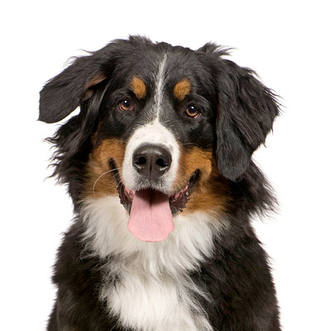

In [9]:
cat = generate_image_array('C:/AI/Cell_Net_v2/test_image/test_2.jpg', 331, 331)
dog = generate_image_array('C:/AI/Cell_Net_v2/test_image/test.jpg', 331, 331)
cat_raw = generate_image('C:/AI/Cell_Net_v2/test_image/test_2.jpg', 331, 331)
dog_raw = generate_image('C:/AI/Cell_Net_v2/test_image/test.jpg', 331, 331)
dog_raw

In [8]:
cell_net_model = 'C:/AI/Cell_Net_Raw/model/cell_net'
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(cell_net_model + '.meta')
    new_saver.restore(sess, cell_net_model)
    soft_max_pna = tf.get_default_graph().get_tensor_by_name("final_layer/predictions:0")
    X = tf.get_default_graph().get_tensor_by_name("input:0")
    y_raw = soft_max_pna.eval(feed_dict={X: dog})
    
frame = pd.DataFrame(y_raw)
item = frame.iloc[0,:]
item = pd.Series.idxmax(item)
item

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_Raw/model/cell_net


240

In [ ]:
with tf.Session() as sess:
    #restore graph from meta and restore variables
    new_saver = tf.train.import_meta_graph(cell_net_model + '.meta')
    new_saver.restore(sess, cell_net_model)
    soft = tf.get_default_graph().get_tensor_by_name("DNN_Classifier/Softmax:0")
    steps = tf.get_default_graph().get_tensor_by_name("DNN_Classifier/train/global_step:0")
    current_step = steps.eval()

In [38]:
with tf.Session() as sess:
    #restore graph from meta and restore variables
    new_saver = tf.train.import_meta_graph(cell_net_best + '.meta')
    new_saver.restore(sess, cell_net_best)
    soft = tf.get_default_graph().get_tensor_by_name("DNN_Classifier/Final_Layer/Softmax:0")
    input_tensor = tf.get_default_graph().get_tensor_by_name("input:0")
    val = soft.eval(feed_dict={input_tensor: cat})

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_v3/model/cell_net_best


In [39]:
val


array([[ 0.04368506,  0.95631492]], dtype=float32)

In [20]:
predictor = Binary_Categorical_Predictor(cell_net_model, labels)

In [ ]:
predictor.print_image_probability('C:/tmp/Cell_Net_v2/test_image/test.jpg')

In [ ]:
frame

In [ ]:
list = np.reshape(last_layers, (num_epochs,batch_size,4320))

In [ ]:
list

In [18]:
with tf.Session() as sess:
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, cell_net_model)
    
    #Set up the global steps
    total_steps = tf.train.global_step(sess, global_step)
    
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " time.")
    print("Done!")

INFO:tensorflow:Restoring parameters from C:/AI/Cell_Net_v2/model/cell_net
Did 488 of loss minimized training in 672.7426071166992 time.
Done!


In [17]:
final_time

672.7426071166992